In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
!cp -r drive/MyDrive/data/project_jl/. .
!pip install scipy
!pip install yfinance --upgrade --no-cache-dir

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.optimize as sco
import warnings, csv
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [27]:
import pandas as pd
spot_name = 'binance_book_snapshot_5_2025-05-22_BTCUSDT.csv.gz'
data_spot = pd.read_csv(spot_name, compression='gzip')
trade_name = 'merged_data.csv'
data_trade = pd.read_csv(trade_name)
futures_name = 'binance-futures_book_snapshot_5_2025-05-22_BTCUSDT.csv.gz'
data_futures = pd.read_csv(futures_name, compression='gzip')


In [38]:
df_spot = data_spot.copy()
df_trade = data_trade.copy()
df_futures = data_futures.copy()
df_spot = df_spot.set_index(pd.DatetimeIndex(df_spot['timestamp']))
df_futures = df_futures.set_index(pd.DatetimeIndex(df_futures['timestamp']))
print(df_futures.info())
print(df_spot.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1478857 entries, 1970-01-21 05:31:12.000313 to 1970-01-21 05:32:38.399882
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   exchange         1478857 non-null  object 
 1   symbol           1478857 non-null  object 
 2   timestamp        1478857 non-null  int64  
 3   local_timestamp  1478857 non-null  int64  
 4   asks[0].price    1478857 non-null  float64
 5   asks[0].amount   1478857 non-null  float64
 6   bids[0].price    1478857 non-null  float64
 7   bids[0].amount   1478857 non-null  float64
 8   asks[1].price    1478857 non-null  float64
 9   asks[1].amount   1478857 non-null  float64
 10  bids[1].price    1478857 non-null  float64
 11  bids[1].amount   1478857 non-null  float64
 12  asks[2].price    1478857 non-null  float64
 13  asks[2].amount   1478857 non-null  float64
 14  bids[2].price    1478857 non-null  float64
 15  bids[2].amount   14

In [75]:
df_1 = pd.DataFrame({
    'spot_ask_price': df_spot['asks[0].price'],
    'swap_bid_price': df_futures['bids[0].price'],
    'swap_ask_price': df_futures['asks[0].price'],
    'spot_bid_price': df_spot['bids[0].price']
})

display(df_1.head())

,spot_ask_price,swap_bid_price,swap_ask_price,spot_bid_price
timestamp,,,,
1970-01-21 05:31:12.000313000,NaN,109609.5,109609.6,NaN
1970-01-21 05:31:12.000858313,109669.91,NaN,NaN,109669.9
1970-01-21 05:31:12.000914801,109669.91,NaN,NaN,109669.9
1970-01-21 05:31:12.001014584,109669.91,NaN,NaN,109669.9
1970-01-21 05:31:12.001114515,109669.91,NaN,NaN,109669.9


In [76]:
df_1['spot_ask_price'].fillna(method='ffill', inplace=True)
df_1['swap_bid_price'].fillna(method='ffill', inplace=True)
df_1['swap_ask_price'].fillna(method='ffill', inplace=True)
df_1['spot_bid_price'].fillna(method='ffill', inplace=True)
display(df_1.head())

,spot_ask_price,swap_bid_price,swap_ask_price,spot_bid_price
timestamp,,,,
1970-01-21 05:31:12.000313000,NaN,109609.5,109609.6,NaN
1970-01-21 05:31:12.000858313,109669.91,109609.5,109609.6,109669.9
1970-01-21 05:31:12.000914801,109669.91,109609.5,109609.6,109669.9
1970-01-21 05:31:12.001014584,109669.91,109609.5,109609.6,109669.9
1970-01-21 05:31:12.001114515,109669.91,109609.5,109609.6,109669.9


In [80]:
df_1['basis2'] = df_1['swap_bid_price'] - df_1['spot_ask_price']
df_1['basis1'] = df_1['swap_ask_price'] - df_1['spot_bid_price']
display(df_1.head())

,spot_ask_price,swap_bid_price,swap_ask_price,spot_bid_price,basis2,basis1
timestamp,,,,,,
1970-01-21 05:31:12.000313000,NaN,109609.5,109609.6,NaN,NaN,NaN
1970-01-21 05:31:12.000858313,109669.91,109609.5,109609.6,109669.9,-60.41,-60.3
1970-01-21 05:31:12.000914801,109669.91,109609.5,109609.6,109669.9,-60.41,-60.3
1970-01-21 05:31:12.001014584,109669.91,109609.5,109609.6,109669.9,-60.41,-60.3
1970-01-21 05:31:12.001114515,109669.91,109609.5,109609.6,109669.9,-60.41,-60.3


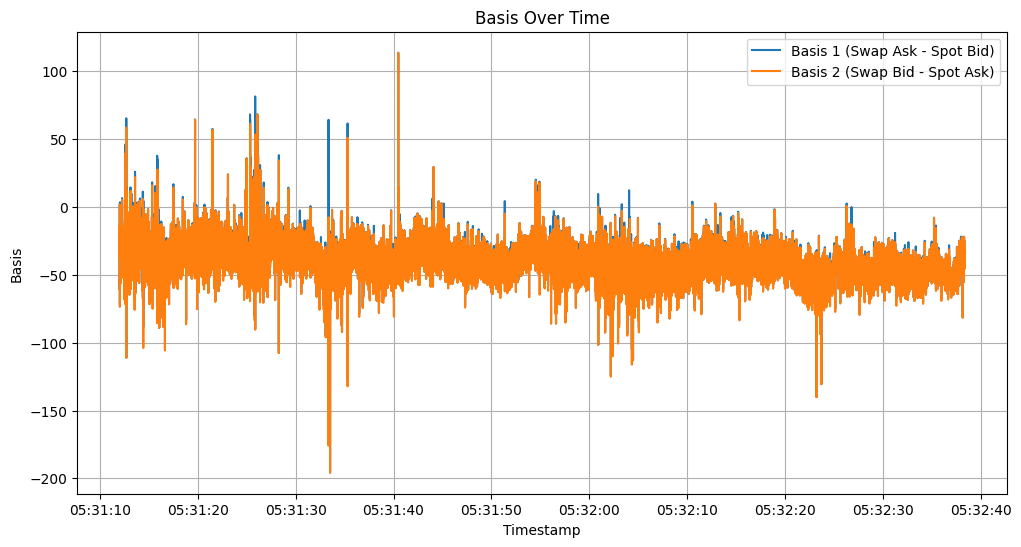

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(df_1.index, df_1['basis1'], label='Basis 1 (Swap Ask - Spot Bid)')
plt.plot(df_1.index, df_1['basis2'], label='Basis 2 (Swap Bid - Spot Ask)')
plt.title('Basis Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Basis')
plt.grid(True)
plt.legend()
plt.show()

In [79]:
display(df_1.describe())

,spot_ask_price,swap_bid_price,swap_ask_price,spot_bid_price,basis2,basis1
count,2.257948e+06,2.257949e+06,2.257949e+06,2.257948e+06,2.257948e+06,2.257948e+06
mean,1.109864e+05,1.109465e+05,1.109466e+05,1.109863e+05,-3.989310e+01,3.975748e+01
std,5.118946e+02,5.094863e+02,5.094827e+02,5.118953e+02,9.418583e+00,9.426795e+00
min,1.091906e+05,1.091534e+05,1.091565e+05,1.091905e+05,-1.958300e+02,-1.136200e+02
25%,1.107220e+05,1.106834e+05,1.106835e+05,1.107220e+05,-4.652000e+01,3.306000e+01
50%,1.110382e+05,1.109938e+05,1.109939e+05,1.110381e+05,-4.012000e+01,4.000000e+01
75%,1.113676e+05,1.113288e+05,1.113289e+05,1.113676e+05,-3.320000e+01,4.640000e+01
max,1.119800e+05,1.119571e+05,1.119572e+05,1.119800e+05,1.135100e+02,1.957200e+02


In [63]:
display(df_1['basis'].describe())

,basis
count,2.257948e+06
mean,-3.989310e+01
std,9.418583e+00
min,-1.958300e+02
25%,-4.652000e+01
50%,-4.012000e+01
75%,-3.320000e+01
max,1.135100e+02


# Task
Analyze trade data (`df_trade`).

## Display head and info

### Subtask:
Show the first few rows and the information about the columns in `df_trade` to get an initial understanding of the data.


**Reasoning**:
Display the first few rows and the information about the columns in `df_trade` to get an initial understanding of the data as instructed.



In [64]:
display(df_trade.head())
display(df_trade.info())

,datetime,spot_symbol,swap_symbol,signal,spot_client_oid,swap_client_oid,threshold,expected_spot_price,expected_swap_price,expected_basis,...,end_calculate_ts,place_order_time,spot_wss_intime,spot_wss_outtime,swap_wss_intime,swap_wss_outtime,spot_order_time,spot_update_time,swap_order_time,swap_update_time
0,2025-10-01T13:54:54.538Z,ALPINE-USDT,ALPINEUSDTM,Close2,sc2CxaKEBAFz89K1DWyGu55Nc3Oas8w2,fc2CxaKEBAFz89K1DWyGu55Nc3Oas8w2,-0.00035,2.04500,2.04380,-0.000587,...,1759326894538,1759326894538,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12
1,2025-10-01T13:55:52.854Z,ALPINE-USDT,ALPINEUSDTM,Close2,sc2Gdzy62FO2w0emIIDZiL1M8vBPFasM,fc2Gdzy62FO2w0emIIDZiL1M8vBPFasM,-0.00035,2.05200,2.05120,-0.000390,...,1759326952853,1759326952854,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12
2,2025-10-01T13:55:52.881Z,ALPINE-USDT,ALPINEUSDTM,Close2,sc2iGMRaeFHFFGyDaLCRTmLRPPlZcEID,fc2iGMRaeFHFFGyDaLCRTmLRPPlZcEID,-0.00035,2.05200,2.05120,-0.000390,...,1759326952880,1759326952881,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12
3,2025-10-01T13:55:52.902Z,ALPINE-USDT,ALPINEUSDTM,Close2,sc2RLR2GqBIKkHNrYRLbVeR53gXHpCyl,fc2RLR2GqBIKkHNrYRLbVeR53gXHpCyl,-0.00035,2.05200,2.05120,-0.000390,...,1759326952901,1759326952902,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12
4,2025-10-01T13:56:41.186Z,AVNT-USDT,AVNTUSDTM,Open2,so2M92KJBDs4PnLqNkFzP2Rz12WLubWR,fo2M92KJBDs4PnLqNkFzP2Rz12WLubWR,-0.00054,1.26002,1.25966,-0.000286,...,1759327001186,1759327001186,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33814 entries, 0 to 33813
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             33814 non-null  object 
 1   spot_symbol          33814 non-null  object 
 2   swap_symbol          33814 non-null  object 
 3   signal               33807 non-null  object 
 4   spot_client_oid      33814 non-null  object 
 5   swap_client_oid      33814 non-null  object 
 6   threshold            33814 non-null  float64
 7   expected_spot_price  33814 non-null  float64
 8   expected_swap_price  33814 non-null  float64
 9   expected_basis       33814 non-null  float64
 10  expected_spot_size   33814 non-null  float64
 11  expected_swap_size   33814 non-null  int64  
 12  spot_executed_qty    33814 non-null  float64
 13  swap_executed_qty    33814 non-null  float64
 14  spot_avg_price       33814 non-null  float64
 15  swap_avg_price       33814 non-null 

None

## Display descriptive statistics

### Subtask:
Show summary statistics for numerical columns in `df_trade`.


**Reasoning**:
Calculate and display descriptive statistics for all numerical columns in `df_trade`.



In [65]:
display(df_trade.describe())

,threshold,expected_spot_price,expected_swap_price,expected_basis,expected_spot_size,expected_swap_size,spot_executed_qty,swap_executed_qty,spot_avg_price,swap_avg_price,...,end_calculate_ts,place_order_time,spot_wss_intime,spot_wss_outtime,swap_wss_intime,swap_wss_outtime,spot_order_time,spot_update_time,swap_order_time,swap_update_time
count,33814.000000,33814.000000,33814.000000,33814.000000,3.381400e+04,33814.000000,3.381400e+04,33814.000000,33814.000000,33814.000000,...,3.381400e+04,3.381400e+04,3.381100e+04,3.381100e+04,3.381000e+04,3.381000e+04,3.380700e+04,3.380700e+04,2.904800e+04,2.904800e+04
mean,-0.000284,207.415422,207.352041,-0.000216,1.011123e+03,19.745845,1.011118e+03,16.664725,207.387428,187.236216,...,1.759743e+12,1.759743e+12,1.759743e+12,1.759743e+12,1.759743e+12,1.759743e+12,1.759743e+12,1.759743e+12,1.759799e+12,1.759799e+12
std,0.000970,2347.375403,2345.579815,0.001514,3.988432e+04,72.075105,3.988432e+04,66.216200,2347.376190,2345.616773,...,1.978508e+08,1.978508e+08,1.978563e+08,1.978563e+08,1.978540e+08,1.978540e+08,1.978677e+08,1.978677e+08,1.499412e+08,1.499412e+08
min,-0.010460,0.000010,0.000010,-0.015999,2.000000e-03,1.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12,1.759327e+12
25%,-0.000610,0.923825,0.920100,-0.000871,1.000000e-01,4.000000,1.000000e-01,3.000000,0.923600,0.183202,...,1.759602e+12,1.759602e+12,1.759602e+12,1.759602e+12,1.759602e+12,1.759602e+12,1.759602e+12,1.759602e+12,1.759680e+12,1.759680e+12
50%,-0.000210,133.319500,133.230000,0.000126,2.000000e-01,9.000000,2.000000e-01,6.000000,133.312425,16.451000,...,1.759806e+12,1.759806e+12,1.759806e+12,1.759806e+12,1.759806e+12,1.759806e+12,1.759806e+12,1.759806e+12,1.759842e+12,1.759842e+12
75%,0.000380,174.299000,174.352500,0.000646,1.200000e+01,14.000000,1.200000e+01,13.000000,174.299000,160.827500,...,1.759929e+12,1.759929e+12,1.759929e+12,1.759929e+12,1.759929e+12,1.759929e+12,1.759929e+12,1.759929e+12,1.759936e+12,1.759936e+12
max,0.003520,123263.200000,123168.000000,0.008857,4.680000e+06,6362.000000,4.680000e+06,6362.000000,123263.200000,123168.000000,...,1.759975e+12,1.759975e+12,1.759975e+12,1.759975e+12,1.759975e+12,1.759975e+12,1.759975e+12,1.759975e+12,1.759975e+12,1.759975e+12


## Explore unique values

### Subtask:
Check for unique values in categorical columns to understand the variety of data.


**Reasoning**:
Select object type columns and then calculate the number of unique values for each of these columns.



In [66]:
object_columns = df_trade.select_dtypes(include='object').columns

for col in object_columns:
    unique_count = df_trade[col].nunique()
    print(f"Column '{col}': {unique_count} unique values")

Column 'datetime': 33794 unique values
Column 'spot_symbol': 96 unique values
Column 'swap_symbol': 96 unique values
Column 'signal': 2 unique values
Column 'spot_client_oid': 33814 unique values
Column 'swap_client_oid': 33814 unique values


## Check for missing values

### Subtask:
Identify if there are any missing values in `df_trade`.


**Reasoning**:
Check for missing values in the df_trade DataFrame and sum them for each column.



In [67]:
missing_values = df_trade.isnull().sum()
display(missing_values)

,0
datetime,0
spot_symbol,0
swap_symbol,0
signal,7
spot_client_oid,0
swap_client_oid,0
threshold,0
expected_spot_price,0
expected_swap_price,0
expected_basis,0


## Visualize key distributions

### Subtask:
Create visualizations for relevant columns to understand their distributions.


**Reasoning**:
Create histograms for selected numerical columns and bar plots for selected categorical columns to visualize their distributions and frequencies.



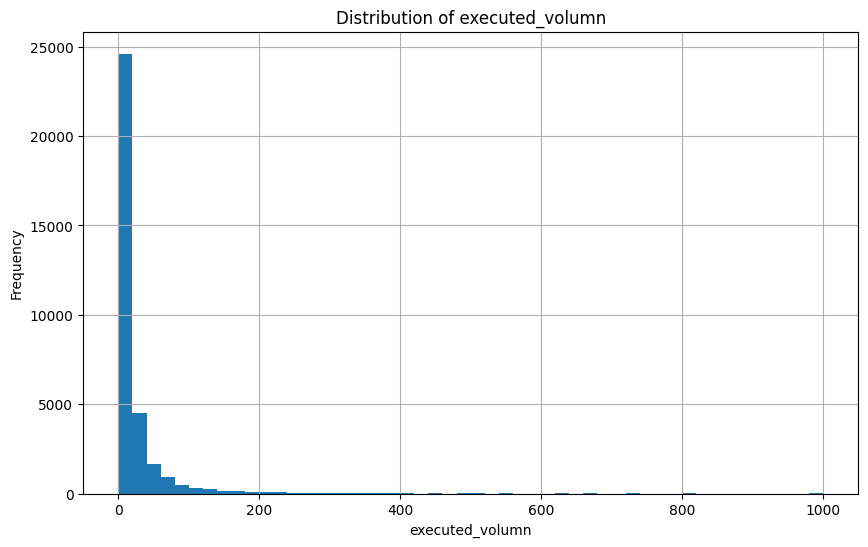

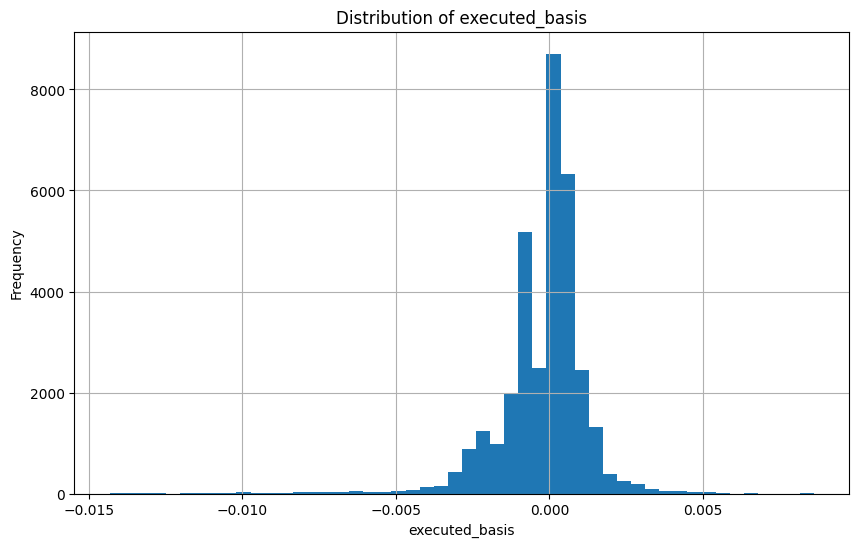

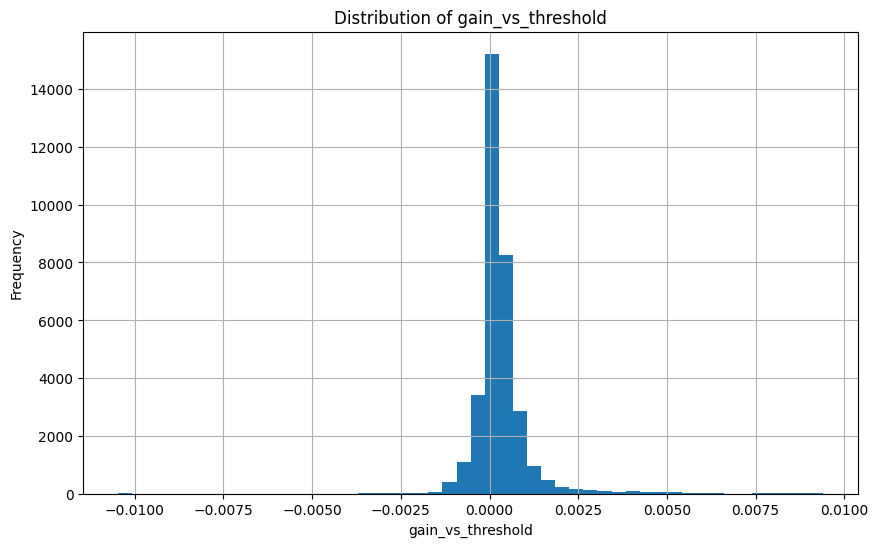

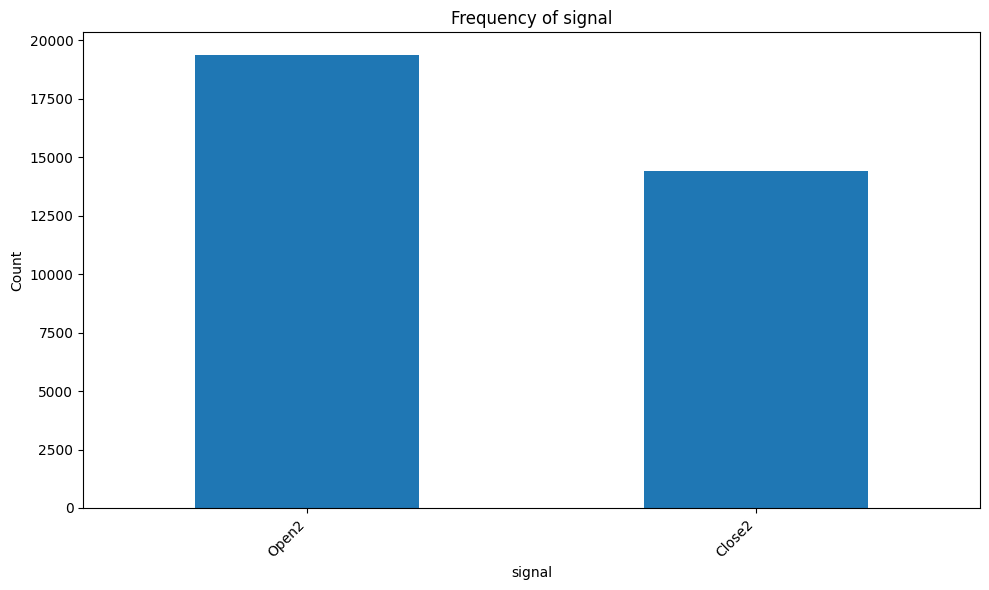

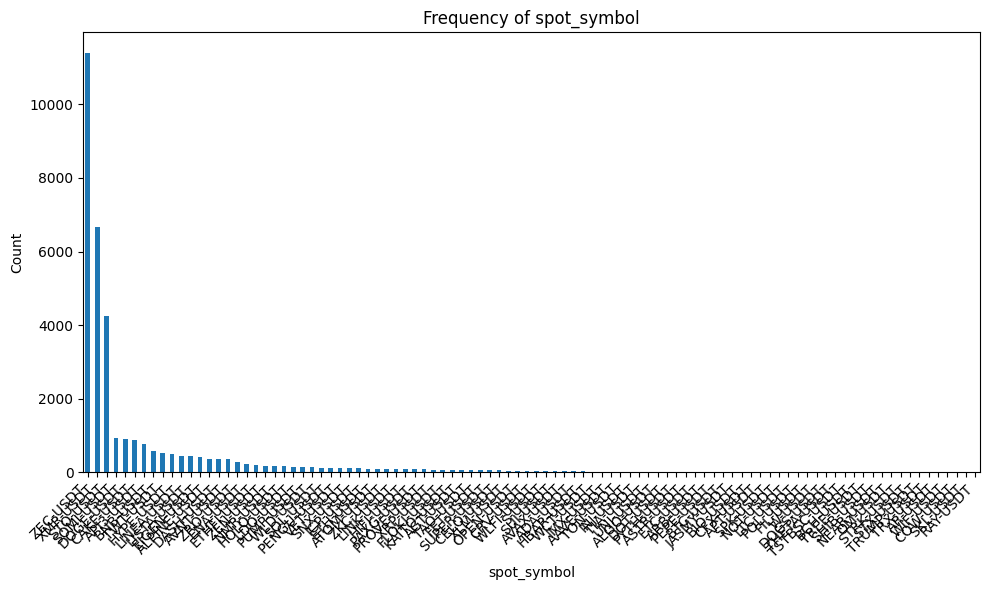

In [68]:
# Select relevant numerical columns for visualization
numerical_cols = ['executed_volumn', 'executed_basis', 'gain_vs_threshold']

# Create histograms for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    plt.hist(df_trade[col].dropna(), bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Select relevant categorical columns for visualization
categorical_cols = ['signal', 'spot_symbol']

# Create count plots for categorical columns
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    df_trade[col].value_counts().plot(kind='bar')
    plt.title(f'Frequency of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Summary:

### Data Analysis Key Findings

*   The `df_trade` DataFrame contains 33,814 entries and 34 columns with various data types.
*   Several columns have missing values, most notably `swap_order_time` and `swap_update_time` with 4766 missing entries each.
*   Columns like `datetime`, `spot_client_oid`, and `swap_client_oid` have a very high number of unique values, close to the total number of rows.
*   `spot_symbol` and `swap_symbol` have 96 unique values, likely representing trading pairs.
*   `signal` is a binary categorical column with 2 unique values.
*   Visualizations were successfully created for the distributions of `executed_volumn`, `executed_basis`, `gain_vs_threshold`, and the frequencies of `signal` and `spot_symbol`.

### Insights or Next Steps

*   Investigate the patterns and potential impact of the missing values in columns like `swap_order_time` and `swap_update_time`.
*   Further analyze the distributions of the numerical and categorical columns to identify any anomalies or significant trends in the trade data.
